This notebook has automated the process of detection of Urban Heat Islands in South Asia

In [1]:
import requests
from datetime import datetime
from bs4 import BeautifulSoup
import os

# Your NASA Earthdata credentials
username = 'faatimaaamir2003'
password = '9W.q364sXu2+GEw'

# MODIS tiles covering Pakistan
tiles = ["h23v06", "h24v05", "h24v06", "h25v05", "h25v06", "h23v07"]

# Time range
start_year = 2000
end_year = 2025
months = [5, 6, 7, 8]  # May to August
days = [1, 9, 17, 25]  # MOD11A2 is an 8-day composite

# Base URL
base_url = 'https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.061/'

# Create session for authentication
session = requests.Session()
session.auth = (username, password)

# Optional: set download directory
os.makedirs("MODIS_MOD11A2", exist_ok=True)

for year in range(start_year, end_year + 1):
    for month in months:
        for day in days:
            try:
                dt = datetime(year, month, day)
                doy = dt.timetuple().tm_yday
                date_str = dt.strftime('%Y.%m.%d')
                folder_url = f"{base_url}{date_str}/"

                # Get directory listing
                print(f"Accessing {folder_url}")
                resp = session.get(folder_url)
                if resp.status_code != 200:
                    print(f"Skipping {date_str}: HTTP {resp.status_code}")
                    continue

                soup = BeautifulSoup(resp.text, 'html.parser')
                links = soup.find_all('a')

                for link in links:
                    href = link.get('href')
                    if not href:
                        continue
                    for tile in tiles:
                        if href.startswith(f"MOD11A2.A{year}{doy:03d}.{tile}.061") and href.endswith(".hdf"):
                            file_url = folder_url + href
                            out_path = os.path.join("MODIS_MOD11A2", href)
                            if os.path.exists(out_path):
                                print(f"Already downloaded: {href}")
                                continue
                            print(f"Downloading {href}")
                            file_resp = session.get(file_url, stream=True)
                            if file_resp.status_code == 200:
                                with open(out_path, 'wb') as f:
                                    for chunk in file_resp.iter_content(chunk_size=8192):
                                        f.write(chunk)
                            else:
                                print(f"Failed to download: {href}")
            except Exception as e:
                print(f"Error on {year}-{month}-{day}: {e}")


Accessing https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.061/2000.05.01/
Skipping 2000.05.01: HTTP 404
Accessing https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.061/2000.05.09/
Skipping 2000.05.09: HTTP 404
Accessing https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.061/2000.05.17/
Skipping 2000.05.17: HTTP 404
Accessing https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.061/2000.05.25/
Skipping 2000.05.25: HTTP 404
Accessing https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.061/2000.06.01/
Already downloaded: MOD11A2.A2000153.h24v05.061.2020051190823.hdf
Already downloaded: MOD11A2.A2000153.h24v06.061.2020051190818.hdf
Already downloaded: MOD11A2.A2000153.h25v05.061.2020051190818.hdf
Already downloaded: MOD11A2.A2000153.h25v06.061.2020051190817.hdf
Accessing https://e4ftl01.cr.usgs.gov/MOLT/MOD11A2.061/2000.06.09/
Already downloaded: MOD11A2.A2000161.h24v05.061.2020051191634.hdf
Already downloaded: MOD11A2.A2000161.h24v06.061.2020051191630.hdf
Already downloaded: MOD11A2.A2000161.h25v05.061.2020051191629.hdf
Already download

In [3]:
import rasterio
import h5py
import numpy as np
import glob
import matplotlib.pyplot as plt
from osgeo import gdal
import geopandas as gpd
from shapely.geometry import box
import os

In [3]:
gdal.UseExceptions()  # Enable detailed error messages

# Define function to extract LST_Day_1km subdataset path from HDF
def extract_lst_subdataset(hdf_file):
    dataset = gdal.Open(hdf_file)
    subdatasets = dataset.GetSubDatasets()
    for subdataset in subdatasets:
        if 'LST_Day_1km' in subdataset[0]:
            return subdataset[0]  # Return the subdataset path
    return None

# List all HDF files
hdf_files = sorted(glob.glob("MODIS_MOD11A2/*.hdf"))

# Output folder for GeoTIFFs
os.makedirs("Extracted_LST_TIFFs", exist_ok=True)

# Loop through HDFs and extract LST
for hdf_path in hdf_files:
    lst_subdataset = extract_lst_subdataset(hdf_path)
    if lst_subdataset:
        output_name = os.path.basename(hdf_path).replace(".hdf", "_LST.tif")
        output_path = os.path.join("Extracted_LST_TIFFs", output_name)
        if not os.path.exists(output_path):
            print(f"Extracting {output_name}")
            gdal.Translate(output_path, lst_subdataset)
        else:
            print(f"Already exists: {output_name}")
    else:
        print(f"LST subdataset not found in {hdf_path}")

Already exists: MOD11A2.A2000153.h23v05.061.2020051190822_LST.tif
Extracting MOD11A2.A2000153.h23v06.061.2020051190814_LST.tif
Extracting MOD11A2.A2000153.h23v07.061.2020051190827_LST.tif
Already exists: MOD11A2.A2000153.h24v05.061.2020051190823_LST.tif
Already exists: MOD11A2.A2000153.h24v06.061.2020051190818_LST.tif
Already exists: MOD11A2.A2000153.h25v05.061.2020051190818_LST.tif
Already exists: MOD11A2.A2000153.h25v06.061.2020051190817_LST.tif
Already exists: MOD11A2.A2000161.h23v05.061.2020051191626_LST.tif
Extracting MOD11A2.A2000161.h23v06.061.2020051191621_LST.tif
Extracting MOD11A2.A2000161.h23v07.061.2020051191621_LST.tif
Already exists: MOD11A2.A2000161.h24v05.061.2020051191634_LST.tif
Already exists: MOD11A2.A2000161.h24v06.061.2020051191630_LST.tif
Already exists: MOD11A2.A2000161.h25v05.061.2020051191629_LST.tif
Already exists: MOD11A2.A2000161.h25v06.061.2020051191634_LST.tif
Already exists: MOD11A2.A2000169.h23v05.061.2020051192532_LST.tif
Extracting MOD11A2.A2000169.h2

In [4]:
# Scale LST Data (Kelvin → Celsius)
import rasterio
from rasterio import shutil as rio_shutil
import numpy as np

# Input and output directories
input_dir = "Extracted_LST_TIFFs"
output_dir = "Scaled_LST_Celsius"
os.makedirs(output_dir, exist_ok=True)

# Process each GeoTIFF
for tif_file in sorted(os.listdir(input_dir)):
    if tif_file.endswith(".tif"):
        input_path = os.path.join(input_dir, tif_file)
        output_path = os.path.join(output_dir, tif_file.replace("_LST.tif", "_LST_Celsius.tif"))

        if os.path.exists(output_path):
            print(f"Already scaled: {output_path}")
            continue

        with rasterio.open(input_path) as src:
            profile = src.profile
            data = src.read(1).astype(float)

            # Handle MODIS fill value
            data[data == 0] = np.nan

            # Apply scale factor and convert to Celsius
            data_celsius = (data * 0.02) - 273.15

            profile.update(dtype=rasterio.float32, nodata=np.nan)

            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(data_celsius.astype(np.float32), 1)

        print(f"Scaled and saved: {output_path}")


Already scaled: Scaled_LST_Celsius\MOD11A2.A2000153.h23v05.061.2020051190822_LST_Celsius.tif
Scaled and saved: Scaled_LST_Celsius\MOD11A2.A2000153.h23v06.061.2020051190814_LST_Celsius.tif
Scaled and saved: Scaled_LST_Celsius\MOD11A2.A2000153.h23v07.061.2020051190827_LST_Celsius.tif
Already scaled: Scaled_LST_Celsius\MOD11A2.A2000153.h24v05.061.2020051190823_LST_Celsius.tif
Already scaled: Scaled_LST_Celsius\MOD11A2.A2000153.h24v06.061.2020051190818_LST_Celsius.tif
Already scaled: Scaled_LST_Celsius\MOD11A2.A2000153.h25v05.061.2020051190818_LST_Celsius.tif
Already scaled: Scaled_LST_Celsius\MOD11A2.A2000153.h25v06.061.2020051190817_LST_Celsius.tif
Already scaled: Scaled_LST_Celsius\MOD11A2.A2000161.h23v05.061.2020051191626_LST_Celsius.tif
Scaled and saved: Scaled_LST_Celsius\MOD11A2.A2000161.h23v06.061.2020051191621_LST_Celsius.tif
Scaled and saved: Scaled_LST_Celsius\MOD11A2.A2000161.h23v07.061.2020051191621_LST_Celsius.tif
Already scaled: Scaled_LST_Celsius\MOD11A2.A2000161.h24v05.061

In [5]:
# Compute Monthly Mean Composites
import pandas as pd
from collections import defaultdict
from datetime import datetime

# Directories
input_dir = "Scaled_LST_Celsius"
output_dir = "Monthly_Mean_LST"
os.makedirs(output_dir, exist_ok=True)

# Group files by year and month
file_groups = defaultdict(list)

for tif_file in sorted(os.listdir(input_dir)):
    if tif_file.endswith(".tif"):
        parts = tif_file.split(".")
        date_str = parts[1]  # e.g., A2023145 → year = 2023, doy = 145
        year = int(date_str[1:5])
        doy = int(date_str[5:])

        # Convert DOY to month
        dt = datetime(year, 1, 1) + pd.to_timedelta(doy - 1, unit="d")
        month = dt.month

        if month in [5, 6, 7, 8]:
            key = f"{year}_{month:02d}"
            file_groups[key].append(os.path.join(input_dir, tif_file))

# Create mean composites
for key, paths in file_groups.items():
    output_path = os.path.join(output_dir, f"LST_Mean_{key}.tif")
    if os.path.exists(output_path):
        print(f"Already created: {output_path}")
        continue

    print(f"Creating composite: {output_path}")
    arrays = []
    profile = None

    for path in paths:
        with rasterio.open(path) as src:
            arr = src.read(1)
            arr[arr == src.nodata] = np.nan  # Replace nodata with NaN
            arrays.append(arr)
            if profile is None:
                profile = src.profile

    # Compute pixel-wise mean
    mean_array = np.nanmean(arrays, axis=0)

    profile.update(dtype=rasterio.float32, nodata=np.nan)

    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(mean_array.astype(np.float32), 1)


Already created: Monthly_Mean_LST\LST_Mean_2000_06.tif
Already created: Monthly_Mean_LST\LST_Mean_2001_05.tif
Already created: Monthly_Mean_LST\LST_Mean_2002_05.tif
Already created: Monthly_Mean_LST\LST_Mean_2003_05.tif
Already created: Monthly_Mean_LST\LST_Mean_2004_06.tif
Already created: Monthly_Mean_LST\LST_Mean_2005_05.tif
Already created: Monthly_Mean_LST\LST_Mean_2006_05.tif
Already created: Monthly_Mean_LST\LST_Mean_2007_05.tif
Already created: Monthly_Mean_LST\LST_Mean_2008_06.tif
Already created: Monthly_Mean_LST\LST_Mean_2009_05.tif
Already created: Monthly_Mean_LST\LST_Mean_2010_05.tif
Already created: Monthly_Mean_LST\LST_Mean_2011_05.tif
Already created: Monthly_Mean_LST\LST_Mean_2012_06.tif
Already created: Monthly_Mean_LST\LST_Mean_2013_05.tif
Already created: Monthly_Mean_LST\LST_Mean_2014_05.tif
Already created: Monthly_Mean_LST\LST_Mean_2015_05.tif
Already created: Monthly_Mean_LST\LST_Mean_2016_06.tif
Already created: Monthly_Mean_LST\LST_Mean_2017_05.tif
Already cr

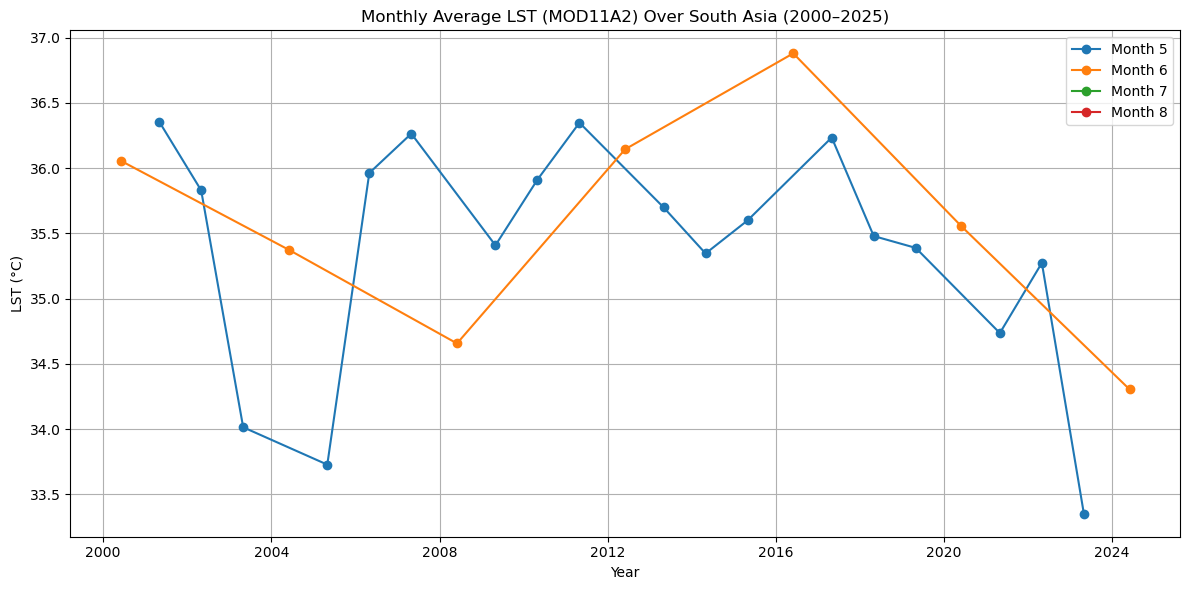

In [6]:
# time series plotting
import os
import matplotlib.pyplot as plt

# Directory where monthly means are stored
mean_dir = "Monthly_Mean_LST"

# Collect all files and extract time info
mean_data = []

for tif_file in sorted(os.listdir(mean_dir)):
    if tif_file.endswith(".tif"):
        parts = tif_file.split("_")  # e.g., LST_Mean_2020_06.tif
        year = int(parts[2])
        month = int(parts[3].split(".")[0])
        path = os.path.join(mean_dir, tif_file)

        with rasterio.open(path) as src:
            arr = src.read(1)
            arr[arr == src.nodata] = np.nan
            mean_temp = np.nanmean(arr)

        mean_data.append((datetime(year, month, 1), mean_temp))

# Create a DataFrame for plotting
df = pd.DataFrame(mean_data, columns=["Date", "Mean_LST"])
df.sort_values("Date", inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
for month in [5, 6, 7, 8]:
    month_df = df[df["Date"].dt.month == month]
    plt.plot(month_df["Date"], month_df["Mean_LST"], marker='o', label=f"Month {month}")

plt.title("Monthly Average LST (MOD11A2) Over South Asia (2000–2025)")
plt.xlabel("Year")
plt.ylabel("LST (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
# Mosaic the extracted files
from osgeo import gdal
import glob
import os
from collections import defaultdict

# Create output directory
os.makedirs("Mosaicked_LST_TIFFs", exist_ok=True)

# Group files by date based on filename pattern
file_groups = defaultdict(list)
for tif_path in glob.glob("Extracted_LST_TIFFs/*_LST.tif"):
    # Extract date string (e.g., A2020153) from filename
    base = os.path.basename(tif_path)
    date_str = base.split('.')[1]  # e.g., 'A2020153'
    file_groups[date_str].append(tif_path)

# Mosaic each group
for date_str, files in file_groups.items():
    output_path = f"Mosaicked_LST_TIFFs/MOD11A2_{date_str}_mosaic.tif"
    if os.path.exists(output_path):
        print(f"Already exists: {output_path}")
        continue

    print(f"Mosaicking {date_str} from {len(files)} tiles...")

    # Create virtual raster (VRT)
    vrt_path = f"/vsimem/{date_str}.vrt"
    gdal.BuildVRT(vrt_path, files)

    # Translate VRT to GeoTIFF
    gdal.Translate(output_path, vrt_path)
    gdal.Unlink(vrt_path)


Mosaicking A2000153 from 7 tiles...
Mosaicking A2000161 from 7 tiles...
Mosaicking A2000169 from 7 tiles...
Mosaicking A2000177 from 7 tiles...
Mosaicking A2001121 from 7 tiles...
Mosaicking A2001129 from 7 tiles...
Mosaicking A2001137 from 7 tiles...
Mosaicking A2001145 from 7 tiles...
Mosaicking A2002121 from 7 tiles...
Mosaicking A2002129 from 7 tiles...
Mosaicking A2002137 from 7 tiles...
Mosaicking A2002145 from 7 tiles...
Mosaicking A2003121 from 7 tiles...
Mosaicking A2003129 from 7 tiles...
Mosaicking A2003137 from 7 tiles...
Mosaicking A2003145 from 7 tiles...
Mosaicking A2004153 from 7 tiles...
Mosaicking A2004161 from 7 tiles...
Mosaicking A2004169 from 7 tiles...
Mosaicking A2004177 from 7 tiles...
Mosaicking A2005121 from 7 tiles...
Mosaicking A2005129 from 7 tiles...
Mosaicking A2005137 from 7 tiles...
Mosaicking A2005145 from 7 tiles...
Mosaicking A2006121 from 7 tiles...
Mosaicking A2006129 from 7 tiles...
Mosaicking A2006137 from 7 tiles...
Mosaicking A2006145 from 7 t

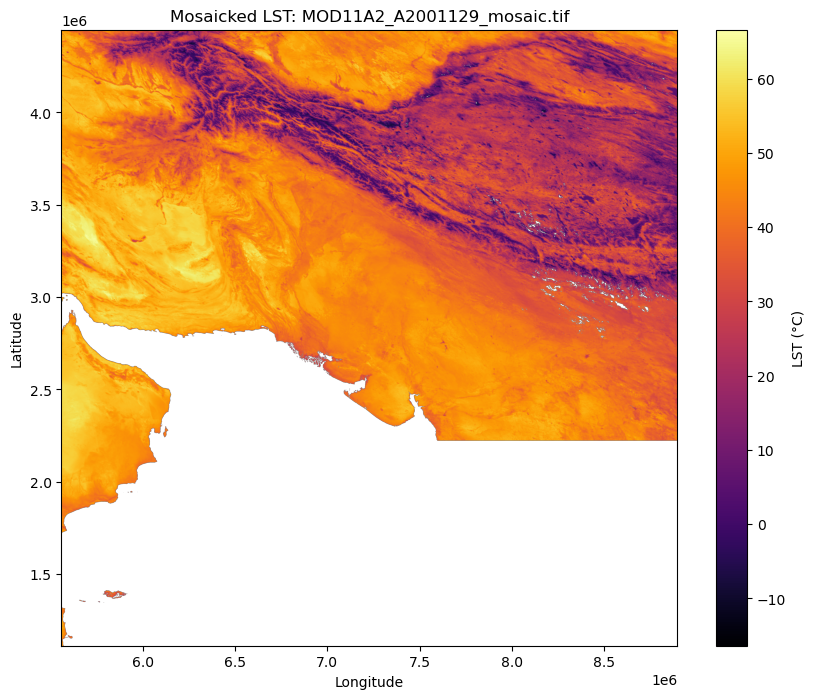

In [11]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

# Select one mosaicked LST TIFF
tif_path = sorted(glob.glob("Mosaicked_LST_TIFFs/*.tif"))[5]  # Change index to view others

with rasterio.open(tif_path) as src:
    lst_data = src.read(1)
    lst_data = np.where(lst_data == 0, np.nan, lst_data)  # Handle fill values
    lst_data_c = (lst_data * 0.02) - 273.15  # Scale and convert to Celsius
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Plot
plt.figure(figsize=(10, 8))
cmap = plt.cm.inferno  # or 'hot', 'plasma', etc.
plt.imshow(lst_data_c, cmap=cmap, extent=extent)
plt.colorbar(label="LST (°C)")
plt.title(f"Mosaicked LST: {os.path.basename(tif_path)}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(False)
plt.show()


In [12]:
# thresholding high temp areas > 40 degress
import numpy as np
import rasterio
from rasterio.mask import mask
import os
import glob

# Threshold temperature in Kelvin (e.g., 40°C = 313.15K)
TEMP_THRESHOLD = 313.15

# Output folder for thresholded binary rasters
os.makedirs("Thresholded_Rasters", exist_ok=True)

# List clipped LST GeoTIFFs
clipped_files = sorted(glob.glob("Mosaicked_LST_TIFFs/*.tif"))

for tif_path in clipped_files:
    with rasterio.open(tif_path) as src:
        lst = src.read(1).astype(np.float32)
        profile = src.profile

        # MODIS LST scaling factor (0.02) and mask for no data
        lst[lst == 0] = np.nan
        lst = lst * 0.02

        # Create binary mask: 1 where LST > threshold, else 0
        binary = np.where(lst > TEMP_THRESHOLD, 1, 0).astype(np.uint8)

        # Update profile to uint8 and remove scale info
        profile.update(dtype=rasterio.uint8, count=1, nodata=0)

        output_path = os.path.join("Thresholded_Rasters", os.path.basename(tif_path).replace("_clipped.tif", "_thresholded.tif"))
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(binary, 1)

        print(f"Thresholded: {output_path}")


Thresholded: Thresholded_Rasters\MOD11A2_A2000153_mosaic.tif
Thresholded: Thresholded_Rasters\MOD11A2_A2000161_mosaic.tif
Thresholded: Thresholded_Rasters\MOD11A2_A2000169_mosaic.tif
Thresholded: Thresholded_Rasters\MOD11A2_A2000177_mosaic.tif
Thresholded: Thresholded_Rasters\MOD11A2_A2001121_mosaic.tif
Thresholded: Thresholded_Rasters\MOD11A2_A2001129_mosaic.tif
Thresholded: Thresholded_Rasters\MOD11A2_A2001137_mosaic.tif
Thresholded: Thresholded_Rasters\MOD11A2_A2001145_mosaic.tif
Thresholded: Thresholded_Rasters\MOD11A2_A2002121_mosaic.tif
Thresholded: Thresholded_Rasters\MOD11A2_A2002129_mosaic.tif
Thresholded: Thresholded_Rasters\MOD11A2_A2002137_mosaic.tif
Thresholded: Thresholded_Rasters\MOD11A2_A2002145_mosaic.tif
Thresholded: Thresholded_Rasters\MOD11A2_A2003121_mosaic.tif
Thresholded: Thresholded_Rasters\MOD11A2_A2003129_mosaic.tif
Thresholded: Thresholded_Rasters\MOD11A2_A2003137_mosaic.tif
Thresholded: Thresholded_Rasters\MOD11A2_A2003145_mosaic.tif
Thresholded: Thresholded

In [13]:
# Vectorize Thresholded Rasters into Shapefiles
import os
import glob
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import shapes
from shapely.geometry import shape

# Create output directory
os.makedirs("Vectorized_UHI_Shapes", exist_ok=True)

for tif_path in sorted(glob.glob("Thresholded_Rasters/*.tif")):
    output_name = os.path.basename(tif_path).replace(".tif", ".shp")
    output_path = os.path.join("Vectorized_UHI_Shapes", output_name)

    with rasterio.open(tif_path) as src:
        image = src.read(1)
        mask = image == 1  # Only vectorize high-temp pixels

        print(f"Vectorizing {output_name}...")
        results = list(
            {"geometry": shape(geom), "properties": {"value": value}}
            for geom, value in shapes(image, mask=mask, transform=src.transform)
        )

        if not results:
            print(f"⚠️  No high-temp areas found in: {output_name}")
            continue  # Skip writing empty shapefile

        gdf = gpd.GeoDataFrame.from_features(results, crs=src.crs)
        gdf.to_file(output_path)

print("✅ Vectorization complete.")


Vectorizing MOD11A2_A2000153_mosaic.shp...
Vectorizing MOD11A2_A2000161_mosaic.shp...
Vectorizing MOD11A2_A2000169_mosaic.shp...
Vectorizing MOD11A2_A2000177_mosaic.shp...
Vectorizing MOD11A2_A2001121_mosaic.shp...
Vectorizing MOD11A2_A2001129_mosaic.shp...
Vectorizing MOD11A2_A2001137_mosaic.shp...
Vectorizing MOD11A2_A2001145_mosaic.shp...
Vectorizing MOD11A2_A2002121_mosaic.shp...
Vectorizing MOD11A2_A2002129_mosaic.shp...
Vectorizing MOD11A2_A2002137_mosaic.shp...
Vectorizing MOD11A2_A2002145_mosaic.shp...
Vectorizing MOD11A2_A2003121_mosaic.shp...
Vectorizing MOD11A2_A2003129_mosaic.shp...
Vectorizing MOD11A2_A2003137_mosaic.shp...
Vectorizing MOD11A2_A2003145_mosaic.shp...
Vectorizing MOD11A2_A2004153_mosaic.shp...
Vectorizing MOD11A2_A2004161_mosaic.shp...
Vectorizing MOD11A2_A2004169_mosaic.shp...
Vectorizing MOD11A2_A2004177_mosaic.shp...
Vectorizing MOD11A2_A2005121_mosaic.shp...
Vectorizing MOD11A2_A2005129_mosaic.shp...
Vectorizing MOD11A2_A2005137_mosaic.shp...
Vectorizing

In [18]:
# group vector files by year for visualization
import os
import glob
import geopandas as gpd
import pandas as pd
from collections import defaultdict

vector_dir = "Vectorized_UHI_Shapes"
output_dir = "Yearly_UHI_Shapes"
os.makedirs(output_dir, exist_ok=True)

# Collect files by year
year_groups = defaultdict(list)
for shp_path in glob.glob(os.path.join(vector_dir, "*.shp")):
    fname = os.path.basename(shp_path)
    if "A" in fname:
        year = fname.split("_A")[1][:4]
        year_groups[year].append(shp_path)

# Merge and export one GeoPackage per year
for year, paths in year_groups.items():
    gdf_list = []
    for path in paths:
        try:
            gdf = gpd.read_file(path)
            if not gdf.empty:
                gdf_list.append(gdf)
        except Exception as e:
            print(f"Error reading {path}: {e}")
    
    if gdf_list:
        merged = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs=gdf_list[0].crs)
        merged.to_file(os.path.join(output_dir, f"UHI_{year}.gpkg"), driver="GPKG")
        print(f"✅ Saved UHI_{year}.gpkg")
    else:
        print(f"⚠️ No data for year {year}")


✅ Saved UHI_2000.gpkg
✅ Saved UHI_2001.gpkg
✅ Saved UHI_2002.gpkg
✅ Saved UHI_2003.gpkg
✅ Saved UHI_2004.gpkg
✅ Saved UHI_2005.gpkg
✅ Saved UHI_2006.gpkg
✅ Saved UHI_2007.gpkg
✅ Saved UHI_2008.gpkg
✅ Saved UHI_2009.gpkg
✅ Saved UHI_2010.gpkg
✅ Saved UHI_2011.gpkg
✅ Saved UHI_2012.gpkg
✅ Saved UHI_2013.gpkg
✅ Saved UHI_2014.gpkg
✅ Saved UHI_2015.gpkg
✅ Saved UHI_2016.gpkg
✅ Saved UHI_2017.gpkg
✅ Saved UHI_2018.gpkg
✅ Saved UHI_2019.gpkg
✅ Saved UHI_2020.gpkg
✅ Saved UHI_2021.gpkg
✅ Saved UHI_2022.gpkg
✅ Saved UHI_2023.gpkg
✅ Saved UHI_2024.gpkg


In [23]:
# visualize yearly changes
import folium
from ipywidgets import interact, widgets
import geopandas as gpd
import os

# Path to yearly GPKGs
yearly_gpkg_dir = "Yearly_UHI_Shapes"
years = sorted([f.split("_")[1].split(".")[0] for f in os.listdir(yearly_gpkg_dir) if f.endswith(".gpkg")])

def show_uhi(year):
    gpkg_path = os.path.join(yearly_gpkg_dir, f"UHI_{year}.gpkg")
    
    try:
        gdf = gpd.read_file(gpkg_path).to_crs(epsg=4326)

        # Create map centered on bounds of the GDF
        bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
        center = [(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2]
        m = folium.Map(location=center, zoom_start=6, tiles='CartoDB positron')

        # Optional: add area in sq.km if not already present
        if 'area_km2' not in gdf.columns:
            gdf = gdf.to_crs(epsg=3857)
            gdf['area_km2'] = gdf.geometry.area / 1e6
            gdf = gdf.to_crs(epsg=4326)

        # Style and tooltip
        folium.GeoJson(
            gdf,
            style_function=lambda x: {
                'fillColor': '#FF5733',
                'color': '#C70039',
                'weight': 1,
                'fillOpacity': 0.5
            },
            tooltip=folium.GeoJsonTooltip(
                fields=['area_km2'],
                aliases=['Area (km²):'],
                localize=True
            ),
            name=f"Urban Heat Islands - {year}"
        ).add_to(m)

        folium.LayerControl(collapsed=False).add_to(m)
        return m

    except Exception as e:
        print(f"Error loading {year}: {e}")
        return folium.Map(location=[30.3753, 69.3451], zoom_start=5, tiles='CartoDB positron')

# Interactive Dropdown
interact(show_uhi, year=widgets.Dropdown(options=years, description='Year:'));



interactive(children=(Dropdown(description='Year:', options=('2000', '2001', '2002', '2003', '2004', '2005', '…

In [20]:
from folium.plugins import HeatMap
import geopandas as gpd
import folium

# Load and reproject to a projected CRS (for centroid accuracy)
gdf = gpd.read_file("Yearly_UHI_Shapes/UHI_2024.gpkg")
gdf_proj = gdf.to_crs(epsg=3857)
gdf_proj['centroid'] = gdf_proj.geometry.centroid

# Convert centroids back to WGS84
gdf['centroid'] = gdf_proj['centroid'].to_crs(epsg=4326)

# Create heatmap data
heat_data = [[pt.y, pt.x] for pt in gdf['centroid'].geometry]

# Use string keys to avoid float interpretation error
custom_gradient = {
    "0.2": 'orange',
    "0.5": 'yellow',
    "0.8": 'red'
}

# Create map
m = folium.Map(location=[30.3753, 69.3451], zoom_start=5, tiles='CartoDB positron')
HeatMap(
    heat_data,
    radius=8,
    blur=12,
    min_opacity=0.2,
    gradient=custom_gradient
).add_to(m)

m


In [1]:
import folium
from folium.plugins import HeatMap
import geopandas as gpd
from ipywidgets import interact, widgets
import os

# Folder containing yearly GPKG files
yearly_gpkg_dir = "Yearly_UHI_Shapes"
years = sorted([f.split("_")[1].split(".")[0] for f in os.listdir(yearly_gpkg_dir) if f.endswith(".gpkg")])

# Center map on Pakistan
m_center = [30.3753, 69.3451]  # Rough center

# Define custom gradient
custom_gradient = {
    "0.2": 'orange',
    "0.5": 'yellow',
    "0.8": 'red'
}

def show_uhi_heatmap(year):
    # Load and reproject to projected CRS for accurate centroid calculation
    gpkg_path = os.path.join(yearly_gpkg_dir, f"UHI_{year}.gpkg")
    gdf = gpd.read_file(gpkg_path)
    
    if gdf.empty:
        print(f"No data for year {year}")
        return folium.Map(location=m_center, zoom_start=5, tiles='CartoDB positron')

    gdf_proj = gdf.to_crs(epsg=3857)
    gdf_proj['centroid'] = gdf_proj.geometry.centroid

    # Convert centroids back to WGS84
    gdf['centroid'] = gdf_proj['centroid'].to_crs(epsg=4326)

    # Create heatmap data
    heat_data = [[pt.y, pt.x] for pt in gdf['centroid'].geometry]

    # Create folium map
    m = folium.Map(location=m_center, zoom_start=5, tiles='CartoDB positron')
    HeatMap(
        heat_data,
        radius=8,
        blur=12,
        min_opacity=0.2,
        gradient=custom_gradient
    ).add_to(m)

    return m

# Create interactive widget
interact(show_uhi_heatmap, year=widgets.Dropdown(options=years, description='Year:'))


interactive(children=(Dropdown(description='Year:', options=('2000', '2001', '2002', '2003', '2004', '2005', '…

<function __main__.show_uhi_heatmap(year)>

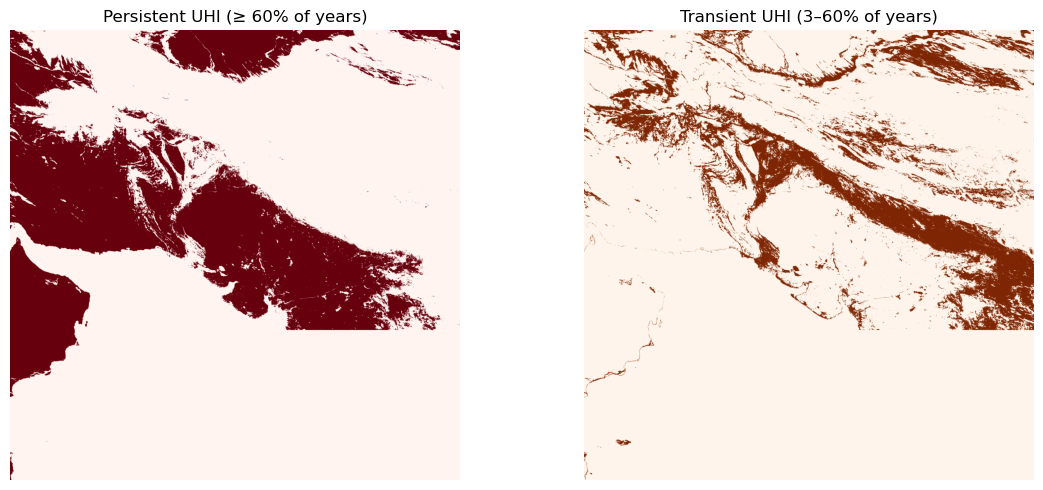

In [31]:
import numpy as np
import rasterio
import glob
import os
import matplotlib.pyplot as plt

# Load thresholded binary UHI rasters
thresholded_dir = "Thresholded_Rasters"
uhi_files = sorted(glob.glob(os.path.join(thresholded_dir, "*.tif")))
uhi_stack = []

for f in uhi_files:
    with rasterio.open(f) as src:
        uhi_stack.append(src.read(1))

uhi_stack = np.stack(uhi_stack)
total_years = uhi_stack.shape[0]

# Calculate UHI frequency map
uhi_occurrence = np.sum(uhi_stack, axis=0)

# Set thresholds
min_valid_years = 3  # ignore < 3 occurrences (noise)
persistent_thresh = int(0.6 * total_years)  # ~60% of years

# Apply classification
persistent_mask = (uhi_occurrence >= persistent_thresh).astype(np.uint8)
transient_mask = ((uhi_occurrence >= min_valid_years) & 
                  (uhi_occurrence < persistent_thresh)).astype(np.uint8)

# Save results
output_dir = "UHI_Persistence_Maps"
os.makedirs(output_dir, exist_ok=True)

with rasterio.open(uhi_files[0]) as src:
    meta = src.meta.copy()
meta.update(dtype='uint8', count=1)

with rasterio.open(os.path.join(output_dir, "Persistent_UHI.tif"), 'w', **meta) as dst:
    dst.write(persistent_mask, 1)

with rasterio.open(os.path.join(output_dir, "Transient_UHI.tif"), 'w', **meta) as dst:
    dst.write(transient_mask, 1)

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(persistent_mask, cmap='Reds')
plt.title("Persistent UHI (≥ 60% of years)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transient_mask, cmap='Oranges')
plt.title("Transient UHI (3–60% of years)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
# manually dowloaded pdf osm files from geofabrick
# conversion from pbf extension to gpkg format
import os
import subprocess

# Set this to the folder containing your .pbf files
pbf_dir = "OSM_Geofabrik"
gpkg_dir = "Geofabrik_GPKG"
os.makedirs(gpkg_dir, exist_ok=True)

# Loop through all PBF files in the folder
for fname in os.listdir(pbf_dir):
    if fname.endswith(".osm.pbf"):
        country_name = fname.replace("-latest.osm.pbf", "")
        pbf_path = os.path.join(pbf_dir, fname)
        gpkg_path = os.path.join(gpkg_dir, f"{country_name}.gpkg")
        
        if os.path.exists(gpkg_path):
            print(f"✓ Skipping (already exists): {gpkg_path}")
            continue

        try:
            print(f"🚀 Converting: {fname} → {gpkg_path}")
            cmd = f'ogr2ogr -f "GPKG" "{gpkg_path}" "{pbf_path}"'
            subprocess.run(cmd, shell=True, check=True)
            print(f"✅ Done: {gpkg_path}")
        except subprocess.CalledProcessError as e:
            print(f"❌ Error converting {fname}: {e}")


🚀 Converting: afghanistan-latest.osm.pbf → Geofabrik_GPKG\afghanistan.gpkg
✅ Done: Geofabrik_GPKG\afghanistan.gpkg
🚀 Converting: china-latest.osm.pbf → Geofabrik_GPKG\china.gpkg
✅ Done: Geofabrik_GPKG\china.gpkg
🚀 Converting: india-latest.osm.pbf → Geofabrik_GPKG\india.gpkg
✅ Done: Geofabrik_GPKG\india.gpkg
🚀 Converting: nepal-latest.osm.pbf → Geofabrik_GPKG\nepal.gpkg
✅ Done: Geofabrik_GPKG\nepal.gpkg
🚀 Converting: pakistan-latest.osm.pbf → Geofabrik_GPKG\pakistan.gpkg
✅ Done: Geofabrik_GPKG\pakistan.gpkg
🚀 Converting: tajikistan-latest.osm.pbf → Geofabrik_GPKG\tajikistan.gpkg
✅ Done: Geofabrik_GPKG\tajikistan.gpkg


In [1]:
# Extract Urban Features from GPKG Files
import os
import fiona
import geopandas as gpd
import pandas as pd

# Input: directory of GPKG files
gpkg_dir = "Geofabrik_GPKG"
output_dir = "Urban_GPKG_Extracts"
os.makedirs(output_dir, exist_ok=True)

# Tags of interest for urban classification
urban_keywords = ['city', 'town', 'suburb', 'residential', 'commercial', 'industrial']

for fname in os.listdir(gpkg_dir):
    if fname.endswith(".gpkg"):
        country = fname.replace(".gpkg", "")
        gpkg_path = os.path.join(gpkg_dir, fname)
        output_path = os.path.join(output_dir, f"urban_{country}.gpkg")

        if os.path.exists(output_path):
            print(f"✓ Skipping (already processed): {output_path}")
            continue

        print(f"🔍 Processing {country}...")

        try:
            # List layers in the GPKG
            layers = fiona.listlayers(gpkg_path)
            
            urban_features = []

            for layer in layers:
                gdf = gpd.read_file(gpkg_path, layer=layer)

                # Filter for columns with 'place' or 'landuse' or any descriptive tags
                for col in gdf.columns:
                    if gdf[col].dtype == object:
                        gdf[col] = gdf[col].fillna("").astype(str)
                        match = gdf[gdf[col].str.lower().isin(urban_keywords)]
                        if not match.empty:
                            urban_features.append(match)

            if urban_features:
                urban_gdf = pd.concat(urban_features, ignore_index=True)
                urban_gdf = gpd.GeoDataFrame(urban_gdf, crs="EPSG:4326")
                urban_gdf = urban_gdf[urban_gdf.geometry.notnull() & ~urban_gdf.geometry.is_empty]
                urban_gdf.to_file(output_path, driver="GPKG")
                print(f"✅ Urban features saved: {output_path}")
            else:
                print(f"⚠️ No urban features found for {country}")

        except Exception as e:
            print(f"❌ Error processing {country}: {e}")


✓ Skipping (already processed): Urban_GPKG_Extracts\urban_afghanistan.gpkg
✓ Skipping (already processed): Urban_GPKG_Extracts\urban_china.gpkg
🔍 Processing india...
✅ Urban features saved: Urban_GPKG_Extracts\urban_india.gpkg
🔍 Processing nepal...
✅ Urban features saved: Urban_GPKG_Extracts\urban_nepal.gpkg
🔍 Processing pakistan...
✅ Urban features saved: Urban_GPKG_Extracts\urban_pakistan.gpkg
🔍 Processing tajikistan...
✅ Urban features saved: Urban_GPKG_Extracts\urban_tajikistan.gpkg


In [5]:
# Classify UHI Zones Using Urban GPKG Overlays
import os
import geopandas as gpd
import pandas as pd

# Paths
uhi_dir = "Yearly_UHI_Shapes"
urban_dir = "Urban_GPKG_Extracts"
output_dir = "UHI_UrbanRural_Classified"
os.makedirs(output_dir, exist_ok=True)

# Load and combine urban features
urban_gdfs = []
for fname in os.listdir(urban_dir):
    if fname.endswith(".gpkg"):
        print(f"Reading urban data: {fname}")
        gdf = gpd.read_file(os.path.join(urban_dir, fname)).to_crs("EPSG:4326")
        urban_gdfs.append(gdf)

urban_all = gpd.GeoDataFrame(pd.concat(urban_gdfs, ignore_index=True), crs="EPSG:4326")
urban_all = urban_all[urban_all.geometry.notnull() & ~urban_all.geometry.is_empty]

# Process each UHI shapefile
for fname in sorted(os.listdir(uhi_dir)):
    if fname.endswith(".gpkg"):
        year = fname.split("_")[1].split(".")[0]
        print(f"Classifying {year}...")

        uhi_path = os.path.join(uhi_dir, fname)
        uhi_gdf = gpd.read_file(uhi_path).to_crs("EPSG:4326")
        uhi_gdf = uhi_gdf.reset_index(drop=True)

        # Add an explicit ID to preserve indexing
        uhi_gdf["UHI_ID"] = uhi_gdf.index

        # Spatial join
        joined = gpd.sjoin(uhi_gdf, urban_all, how="left", predicate="intersects")

        # Get unique UHI_IDs that intersect urban areas
        urban_matches = joined["UHI_ID"].drop_duplicates()

        # Assign Rural by default, Urban where matched
        uhi_gdf["UHI_Type"] = "Rural"
        uhi_gdf.loc[uhi_gdf["UHI_ID"].isin(urban_matches), "UHI_Type"] = "Urban"

        # Save output
        out_path = os.path.join(output_dir, f"UHI_{year}_classified.gpkg")
        uhi_gdf.drop(columns=["UHI_ID"]).to_file(out_path, driver="GPKG")
        print(f"✔ Saved: {out_path}")

Reading urban data: urban_afghanistan.gpkg
Reading urban data: urban_china.gpkg
Reading urban data: urban_india.gpkg
Reading urban data: urban_nepal.gpkg
Reading urban data: urban_pakistan.gpkg
Reading urban data: urban_tajikistan.gpkg
Classifying 2000...
✔ Saved: UHI_UrbanRural_Classified\UHI_2000_classified.gpkg
Classifying 2001...
✔ Saved: UHI_UrbanRural_Classified\UHI_2001_classified.gpkg
Classifying 2002...
✔ Saved: UHI_UrbanRural_Classified\UHI_2002_classified.gpkg
Classifying 2003...
✔ Saved: UHI_UrbanRural_Classified\UHI_2003_classified.gpkg
Classifying 2004...
✔ Saved: UHI_UrbanRural_Classified\UHI_2004_classified.gpkg
Classifying 2005...
✔ Saved: UHI_UrbanRural_Classified\UHI_2005_classified.gpkg
Classifying 2006...
✔ Saved: UHI_UrbanRural_Classified\UHI_2006_classified.gpkg
Classifying 2007...
✔ Saved: UHI_UrbanRural_Classified\UHI_2007_classified.gpkg
Classifying 2008...
✔ Saved: UHI_UrbanRural_Classified\UHI_2008_classified.gpkg
Classifying 2009...
✔ Saved: UHI_UrbanRural_

<Figure size 1200x600 with 0 Axes>

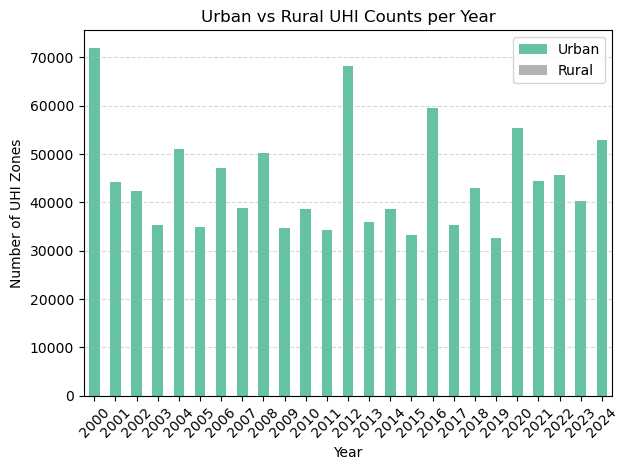

In [7]:
#  UHI Urban vs Rural Summary Dashboard
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths
classified_dir = "UHI_UrbanRural_Classified"

# Collect data for all years
summary_data = []

for fname in sorted(os.listdir(classified_dir)):
    if fname.endswith(".gpkg"):
        year = fname.split("_")[1]
        path = os.path.join(classified_dir, fname)
        
        gdf = gpd.read_file(path)
        counts = gdf["UHI_Type"].value_counts().to_dict()
        
        summary_data.append({
            "Year": int(year),
            "Urban": counts.get("Urban", 0),
            "Rural": counts.get("Rural", 0),
            "Total": sum(counts.values())
        })

# Convert to DataFrame
summary_df = pd.DataFrame(summary_data).sort_values("Year")
summary_df.set_index("Year", inplace=True)

# Plot settings
plt.figure(figsize=(12, 6))
summary_df[["Urban", "Rural"]].plot(kind='bar', stacked=True, colormap="Set2")
plt.title("Urban vs Rural UHI Counts per Year")
plt.ylabel("Number of UHI Zones")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Optional: Save summary as CSV
summary_df.to_csv("UHI_UrbanRural_Summary.csv")
